In [11]:
# ===============================
# Librairies
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA

import tensorflow as tf
from keras import layers, models, callbacks, optimizers, losses, metrics

In [12]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv("../data/Stock_Market_Initial_Data.csv")
df_load

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_5439/4198978970.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


,Date,^GSPC_High,Low,Open,Close,Volume,Adj Close,^IXIC_High,Low,Open,...,Open,Close,Volume,Adj Close,^JN0U.JO_High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.9500122,740.7399902,753.8499756,740.7399902,399760000,740.7399902,1291.880005,1285.449951,1289.23999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/2/1997,742.8099976,729.5499878,740.7399902,737.0100098,463230000,737.0100098,1293.630005,1272.339966,1292.650024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/3/1997,748.2399902,737.0100098,737.0100098,748.0300293,452970000,748.0300293,1310.839966,1280.699951,1288.02002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/6/1997,753.3099976,743.8200073,748.0300293,747.6500244,531350000,747.6500244,1321.469971,1310.630005,1314.339966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/7/1997,753.2600098,742.1799927,747.6500244,753.2299805,538220000,753.2299805,1327.819946,1312.079956,1316.910034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4899000000,3759.689941,10993.24023,10522.90039,10885.00977,...,NaN,NaN,NaN,NaN,3640.830078,3566.639893,3602.090088,3573.790039,0.0,3573.790039
6505,11/3/2022,3750.590088,3698.149902,3733.25,3719.889893,4625290000,3719.889893,10486.00977,10319.54004,10399.4502,...,NaN,NaN,NaN,NaN,3557.22998,3431.080078,3557.0,3474.129883,0.0,3474.129883
6506,11/4/2022,3796.340088,3708.840088,3766.97998,3770.550049,0,3770.550049,10553.62988,10262.92969,10548.13965,...,NaN,NaN,NaN,NaN,3765.290039,3497.070068,3498.77002,3751.629883,0.0,3751.629883
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4341620000,3806.800049,10587.95996,10428.91016,10516.94043,...,NaN,NaN,NaN,NaN,3826.070068,3695.27002,3749.379883,3815.75,0.0,3815.75


In [13]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]
    df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]] = df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, "^GSPC")
df_gspc

,Date,High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.950012,740.739990,753.849976,740.739990,3.997600e+08,740.739990
1,1/2/1997,742.809998,729.549988,740.739990,737.010010,4.632300e+08,737.010010
2,1/3/1997,748.239990,737.010010,737.010010,748.030029,4.529700e+08,748.030029
3,1/6/1997,753.309998,743.820007,748.030029,747.650024,5.313500e+08,747.650024
4,1/7/1997,753.260010,742.179993,747.650024,753.229981,5.382200e+08,753.229981
...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,3759.689941
6505,11/3/2022,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,3719.889893
6506,11/4/2022,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,3770.550049
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4.341620e+09,3806.800049


In [14]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def preprocess_data(df):
    """
    Full preprocessing for OHLCV financial data
    Adds trend, momentum, volatility, OHLC-based, volume, and temporal features
    """

    # Price-based indicators
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

    # Momentum / Returns
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Momentum_4'] = df['Close'] - df['Close'].shift(4)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Relative Strength / Momentum indicators
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    low14 = df['Close'].rolling(14).min()
    high14 = df['Close'].rolling(14).max()
    df['Stochastic_K'] = 100 * (df['Close'] - low14) / (high14 - low14)
    df['Stochastic_D'] = df['Stochastic_K'].rolling(3).mean()

    # Volatility indicators
    df['Volatility_10'] = df['Close'].rolling(10).std()
    df['Volatility_20'] = df['Close'].rolling(20).std()

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['Middle_Band'] = df['Close'].rolling(20).mean()
    df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(20).std() * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(20).std() * 2)
    df['BB_%B'] = (df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])
    
    # Drop NaNs created by rolling/shift
    df.dropna(inplace=True)
    
    return df

df = preprocess_data(df_gspc)
df

,Date,High,Low,Open,Close,Volume,Adj Close,SMA_50,SMA_200,EMA_20,...,Stochastic_K,Stochastic_D,Volatility_10,Volatility_20,MACD,MACD_Signal,Middle_Band,Upper_Band,Lower_Band,BB_%B
199,10/14/1997,972.859985,961.869995,968.099976,970.280029,5.103300e+08,970.280029,938.981000,852.581201,958.358095,...,71.599293,67.558816,7.584680,12.519041,10.407819,9.965106,958.145999,983.184082,933.107917,0.742311
200,10/15/1997,970.280029,962.750000,970.280029,965.719971,5.053100e+08,965.719971,939.247999,853.706101,959.059226,...,54.089675,64.155401,6.149449,12.096009,9.714567,9.914998,959.281998,983.474016,935.089979,0.633060
201,10/16/1997,973.380005,950.770019,965.719971,955.250000,5.970100e+08,955.250000,939.146599,854.797301,958.696443,...,22.237663,49.308877,7.156083,11.808195,8.225503,9.577099,959.679999,983.296388,936.063609,0.406209
202,10/17/1997,955.229981,931.580017,955.229981,944.159973,6.249800e+08,944.159973,939.005999,855.777951,957.312017,...,0.000000,25.442446,10.673954,12.148212,6.080444,8.877768,959.362497,983.658921,935.066073,0.187145
203,10/20/1997,955.719971,941.429993,944.159973,955.609985,4.838800e+08,955.609985,939.447399,856.817751,957.149919,...,29.389132,17.208932,11.036199,12.145212,5.243941,8.151003,959.371497,983.661920,935.081073,0.422572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,3759.689941,3821.862212,4101.216359,3777.747117,...,55.542589,77.476430,69.817359,103.336907,14.836953,-5.819047,3730.511011,3937.184825,3523.837196,0.570592
6505,11/3/2022,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,3719.889893,3813.444609,4097.152009,3772.236905,...,22.998069,54.800620,58.575029,103.307929,7.799778,-3.095282,3729.279504,3935.895362,3522.663647,0.477278
6506,11/4/2022,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,3770.550049,3804.873208,4093.591110,3772.076252,...,44.529925,41.023528,56.693756,101.461170,6.238702,-1.228485,3735.824011,3938.746350,3532.901672,0.585565
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4.341620e+09,3806.800049,3799.856011,4090.635410,3775.383280,...,59.937097,42.488364,56.400715,98.275890,7.836278,0.584467,3745.544519,3942.096299,3548.992739,0.655825


In [15]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'SMA_50',
       'SMA_200', 'EMA_20', 'EMA_50', 'Log_Return', 'Momentum_4',
       'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
       'Volatility_10', 'Volatility_20', 'MACD', 'MACD_Signal', 'Middle_Band',
       'Upper_Band', 'Lower_Band', 'BB_%B'],
      dtype='object')

In [16]:
# ===============================
# Plotting different figures (optional)
# ===============================
"""
# Example: price and moving averages
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='orange')
plt.plot(df['Date'], df['SMA_200'], label='SMA 200', color='green')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price & Moving Averages')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Daily Returns & Log Returns
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['Daily_Return'], label='Daily Return', color='purple')
plt.plot(df['Date'], df['Log_Return'], label='Log Return', color='brown')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Daily and Log Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# RSI & Momentum
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14', color='blue')
plt.plot(df['Date'], df['Momentum_4'], label='Momentum 4', color='orange')
plt.plot(df['Date'], df['Momentum_10'], label='Momentum 10', color='green')
plt.xlabel('Date')
plt.ylabel('Indicator Value')
plt.title('RSI & Momentum Indicators')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bollinger Bands
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['Middle_Band'], label='Middle Band', color='orange')
plt.plot(df['Date'], df['Upper_Band'], label='Upper Band', color='green')
plt.plot(df['Date'], df['Lower_Band'], label='Lower Band', color='red')
plt.fill_between(df['Date'], df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bollinger Bands')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""

"\n# Example: price and moving averages\nplt.figure(figsize=(16, 6))\nplt.plot(df['Date'], df['Close'], label='Close', color='blue')\nplt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='orange')\nplt.plot(df['Date'], df['SMA_200'], label='SMA 200', color='green')\nplt.plot(df['Date'], df['EMA_20'], label='EMA 20', color='red', linestyle='--')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.title('Close Price & Moving Averages')\nplt.legend()\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# Daily Returns & Log Returns\nplt.figure(figsize=(16, 4))\nplt.plot(df['Date'], df['Daily_Return'], label='Daily Return', color='purple')\nplt.plot(df['Date'], df['Log_Return'], label='Log Return', color='brown')\nplt.xlabel('Date')\nplt.ylabel('Returns')\nplt.title('Daily and Log Returns')\nplt.legend()\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# RSI & Momentum\nplt.figure(figsize=(16, 4))\nplt.plot(df['Date'], df['RSI_14'], label='RS

In [17]:
# ===============================
# Drop unused columns and verify data consistency
# ===============================
df_ml = df.copy()

df_ml = df_ml.drop(columns=["Date", "Open", "High", "Low", "Volume", "Adj Close"], errors="ignore")   # Remove non-numeric and useful column
df_ml = df_ml.select_dtypes(include=[np.number]).dropna()

In [18]:
df_ml.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,1800.652282,932.659447,676.530029,1161.087555,1386.919983,2139.174927,4796.560059
SMA_50,6310.0,1789.730290,924.097034,788.956798,1144.508906,1379.013998,2116.683249,4681.011611
SMA_200,6310.0,1752.257996,890.892172,852.581201,1143.284848,1365.271801,2065.261064,4496.905588
EMA_20,6310.0,1796.403606,928.832691,743.372703,1157.973185,1385.079533,2138.139713,4720.631447
EMA_50,6310.0,1789.489094,922.821415,792.835619,1143.127564,1377.612689,2122.922503,4663.258078
Log_Return,6310.0,0.000217,0.012514,-0.127652,-0.005056,0.000608,0.006076,0.109572
Momentum_4,6310.0,1.780079,44.624213,-496.100097,-15.274979,4.370056,21.447449,325.150146
Momentum_10,6310.0,4.512685,68.080100,-732.020019,-19.777527,9.439972,33.947571,426.280030
RSI_14,6310.0,54.478211,15.875957,4.009865,42.755398,54.745423,65.604112,99.298813
Stochastic_K,6310.0,60.343074,36.718644,0.000000,27.177273,69.239453,97.404322,100.000000


In [19]:
df_ml.isna().sum()

Close            0
SMA_50           0
SMA_200          0
EMA_20           0
EMA_50           0
Log_Return       0
Momentum_4       0
Momentum_10      0
RSI_14           0
Stochastic_K     0
Stochastic_D     0
Volatility_10    0
Volatility_20    0
MACD             0
MACD_Signal      0
Middle_Band      0
Upper_Band       0
Lower_Band       0
BB_%B            0
dtype: int64

In [20]:
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna()

In [21]:
df_ml.columns

Index(['Close', 'SMA_50', 'SMA_200', 'EMA_20', 'EMA_50', 'Log_Return',
       'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
       'Volatility_10', 'Volatility_20', 'MACD', 'MACD_Signal', 'Middle_Band',
       'Upper_Band', 'Lower_Band', 'BB_%B'],
      dtype='object')

In [22]:
# ===============================
# Keep historical data for later recursive forecast sequences recalculations
# ===============================
df_raw_hist = df_gspc[['Close']].copy()
df_raw_hist = df_raw_hist.select_dtypes(include=[np.number]).dropna()
df_raw_hist = df_raw_hist.replace([np.inf, -np.inf], np.nan)
df_raw_hist = df_raw_hist.dropna()
df_raw_hist.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,1800.652282,932.659447,676.530029,1161.087555,1386.919983,2139.174927,4796.560059


In [23]:
# ===============================
# Scale price datas not to cause imbalance into the model
# ===============================
# 1. Volume columns
# no need now 

# 2. Price columns
price_cols = ["Close",
    "SMA_50", "SMA_200", "EMA_20", "EMA_50",
    "Middle_Band", "Upper_Band", "Lower_Band"
]
prices_scaler = RobustScaler()
df_ml[price_cols] = prices_scaler.fit_transform(df_ml[price_cols])

indicators_scalers = {}
indicators_cols = [
    'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
    'Volatility_10', 'Volatility_20',
    'MACD', 'MACD_Signal', 'BB_%B'
]
for col in indicators_cols:
    indicators_scalers[col] = RobustScaler()
    df_ml[col] = indicators_scalers[col].fit_transform(df_ml[[col]])

log_return_scaler = RobustScaler()
df_ml["Log_Return"] = log_return_scaler.fit_transform(df_ml[["Log_Return"]])

In [24]:
df_ml.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,0.423001,0.953554,-0.726305,-0.230892,0.000000e+00,0.769108,3.486028
SMA_50,6310.0,0.422472,0.950547,-0.606946,-0.241217,0.000000e+00,0.758783,3.396508
SMA_200,6310.0,0.419736,0.966285,-0.556078,-0.240773,-1.233144e-16,0.759227,3.396654
EMA_20,6310.0,0.419647,0.947627,-0.654692,-0.231702,0.000000e+00,0.768298,3.403046
EMA_50,6310.0,0.420370,0.941852,-0.596836,-0.239321,-1.160367e-16,0.760679,3.353401
Log_Return,6310.0,-0.035063,1.124211,-11.522087,-0.508761,-4.865357e-18,0.491239,9.788698
Momentum_4,6310.0,-0.070528,1.215176,-13.628461,-0.534960,0.000000e+00,0.465040,8.735264
Momentum_10,6310.0,-0.091713,1.267194,-13.800999,-0.543833,0.000000e+00,0.456167,7.758759
RSI_14,6310.0,-0.011695,0.694829,-2.220499,-0.524757,1.554881e-16,0.475243,1.949930
Stochastic_K,6310.0,-0.126680,0.522856,-0.985937,-0.598946,1.011832e-16,0.401054,0.438016


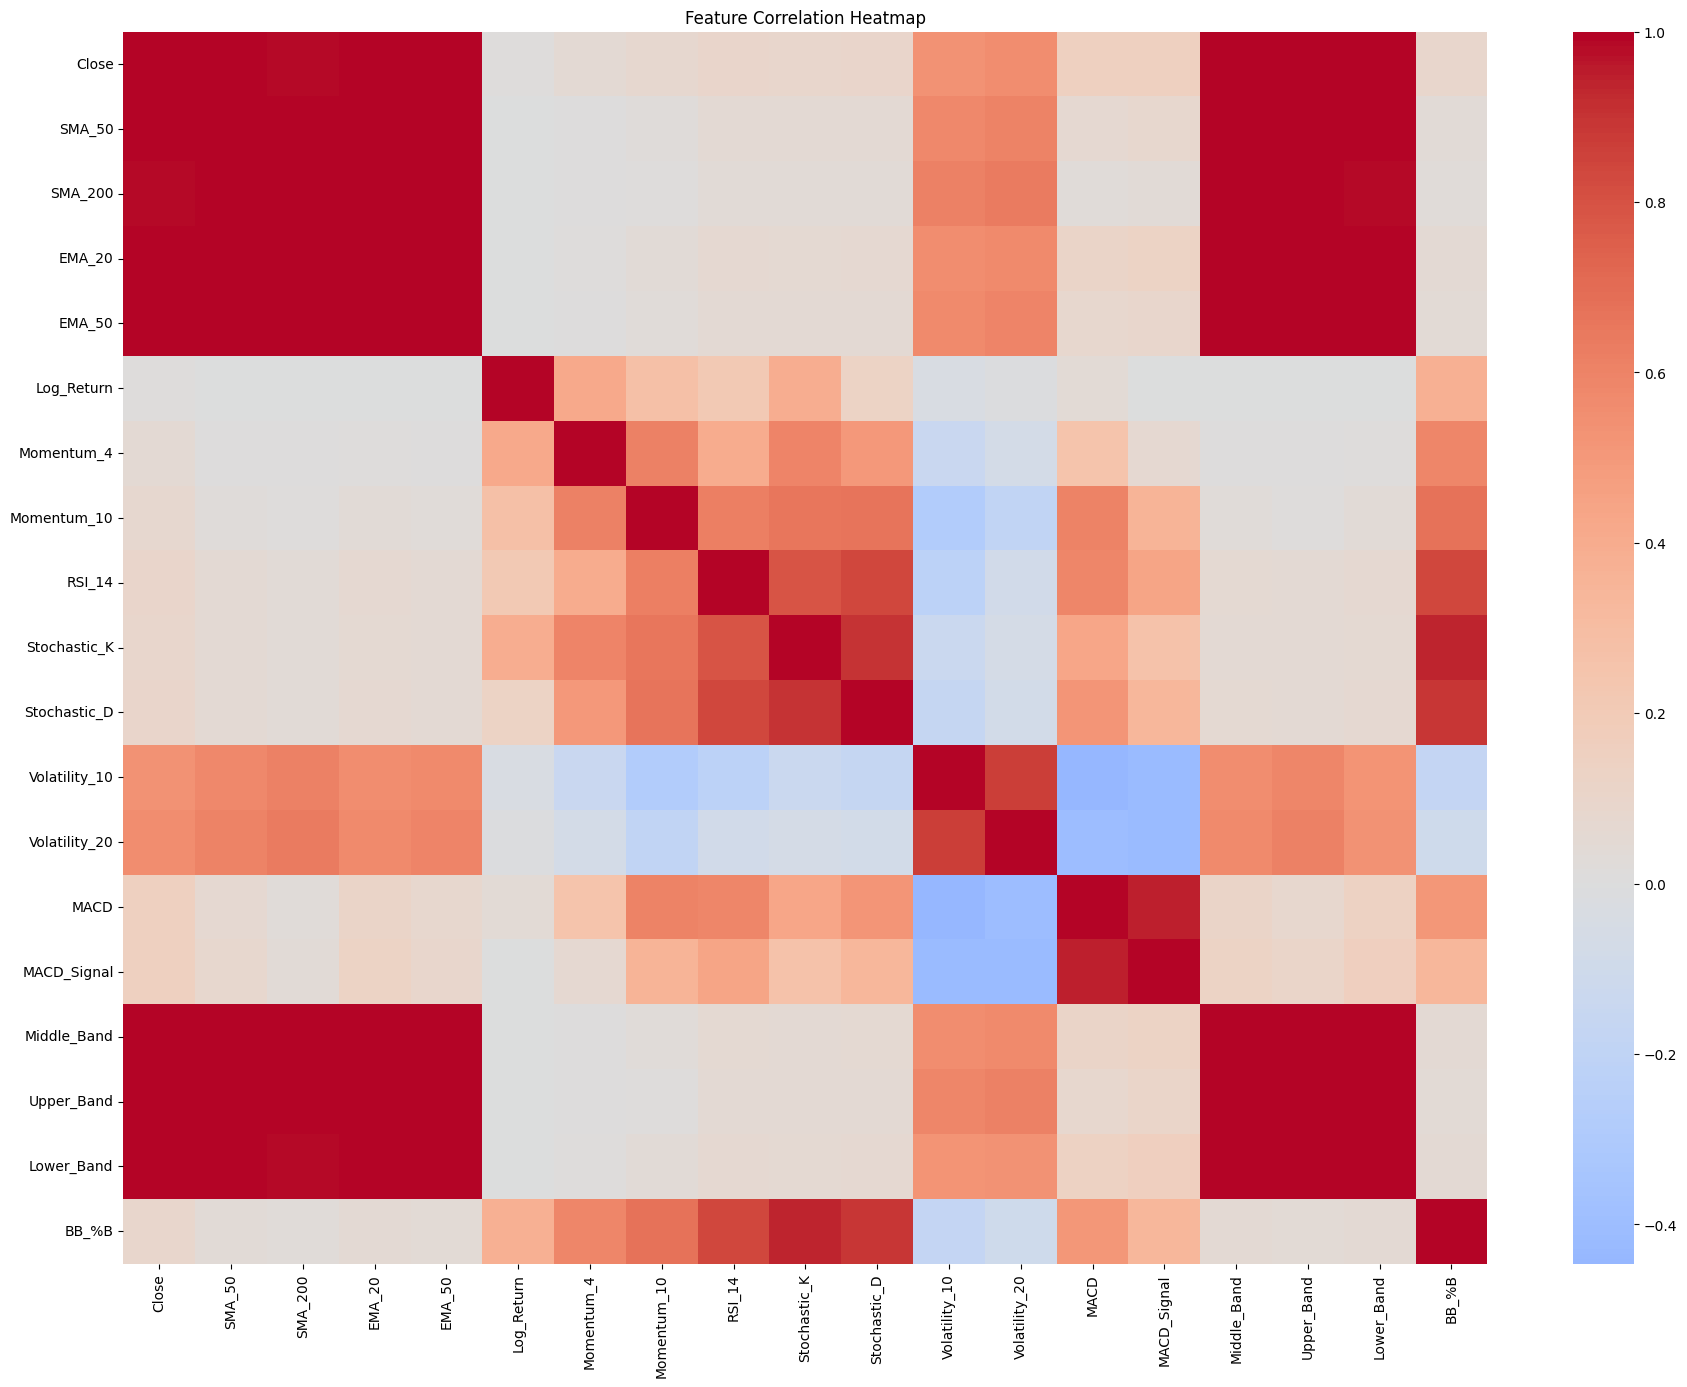

In [25]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(22, 16))
sns.heatmap(df_ml.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [26]:
# ===============================
# Highlighting the higly correlated features
# ===============================
FEATURE_COLS = ['Close',
                'SMA_50', 'SMA_200', 'EMA_20', 'EMA_50', 
                'Momentum_4', 'Momentum_10',
                'RSI_14', 'Stochastic_K', 'Stochastic_D', 
                'Volatility_10', 'Volatility_20', 
                'MACD', 'MACD_Signal',
                'Middle_Band', 'Upper_Band', 'Lower_Band', 'BB_%B'
              ]
X = df_ml[FEATURE_COLS]
corr_matrix =X.corr().abs()
high_corr = np.where(corr_matrix > 0.95)  # threshold 0.95
high_corr_pairs = [(FEATURE_COLS[i], FEATURE_COLS[j]) for i, j in zip(*high_corr) if i != j and i < j]
print("Highly correlated pairs:", high_corr_pairs)

Highly correlated pairs: [('Close', 'SMA_50'), ('Close', 'SMA_200'), ('Close', 'EMA_20'), ('Close', 'EMA_50'), ('Close', 'Middle_Band'), ('Close', 'Upper_Band'), ('Close', 'Lower_Band'), ('SMA_50', 'SMA_200'), ('SMA_50', 'EMA_20'), ('SMA_50', 'EMA_50'), ('SMA_50', 'Middle_Band'), ('SMA_50', 'Upper_Band'), ('SMA_50', 'Lower_Band'), ('SMA_200', 'EMA_20'), ('SMA_200', 'EMA_50'), ('SMA_200', 'Middle_Band'), ('SMA_200', 'Upper_Band'), ('SMA_200', 'Lower_Band'), ('EMA_20', 'EMA_50'), ('EMA_20', 'Middle_Band'), ('EMA_20', 'Upper_Band'), ('EMA_20', 'Lower_Band'), ('EMA_50', 'Middle_Band'), ('EMA_50', 'Upper_Band'), ('EMA_50', 'Lower_Band'), ('Middle_Band', 'Upper_Band'), ('Middle_Band', 'Lower_Band'), ('Upper_Band', 'Lower_Band')]


In [27]:
# ===============================
# Removing those that contains the same information
# ===============================
df_ml = df_ml.drop(columns=['SMA_200', 'EMA_50',
                            'Volatility_20',
                            'MACD',
                            'Middle_Band', 'Lower_Band'
                            ])

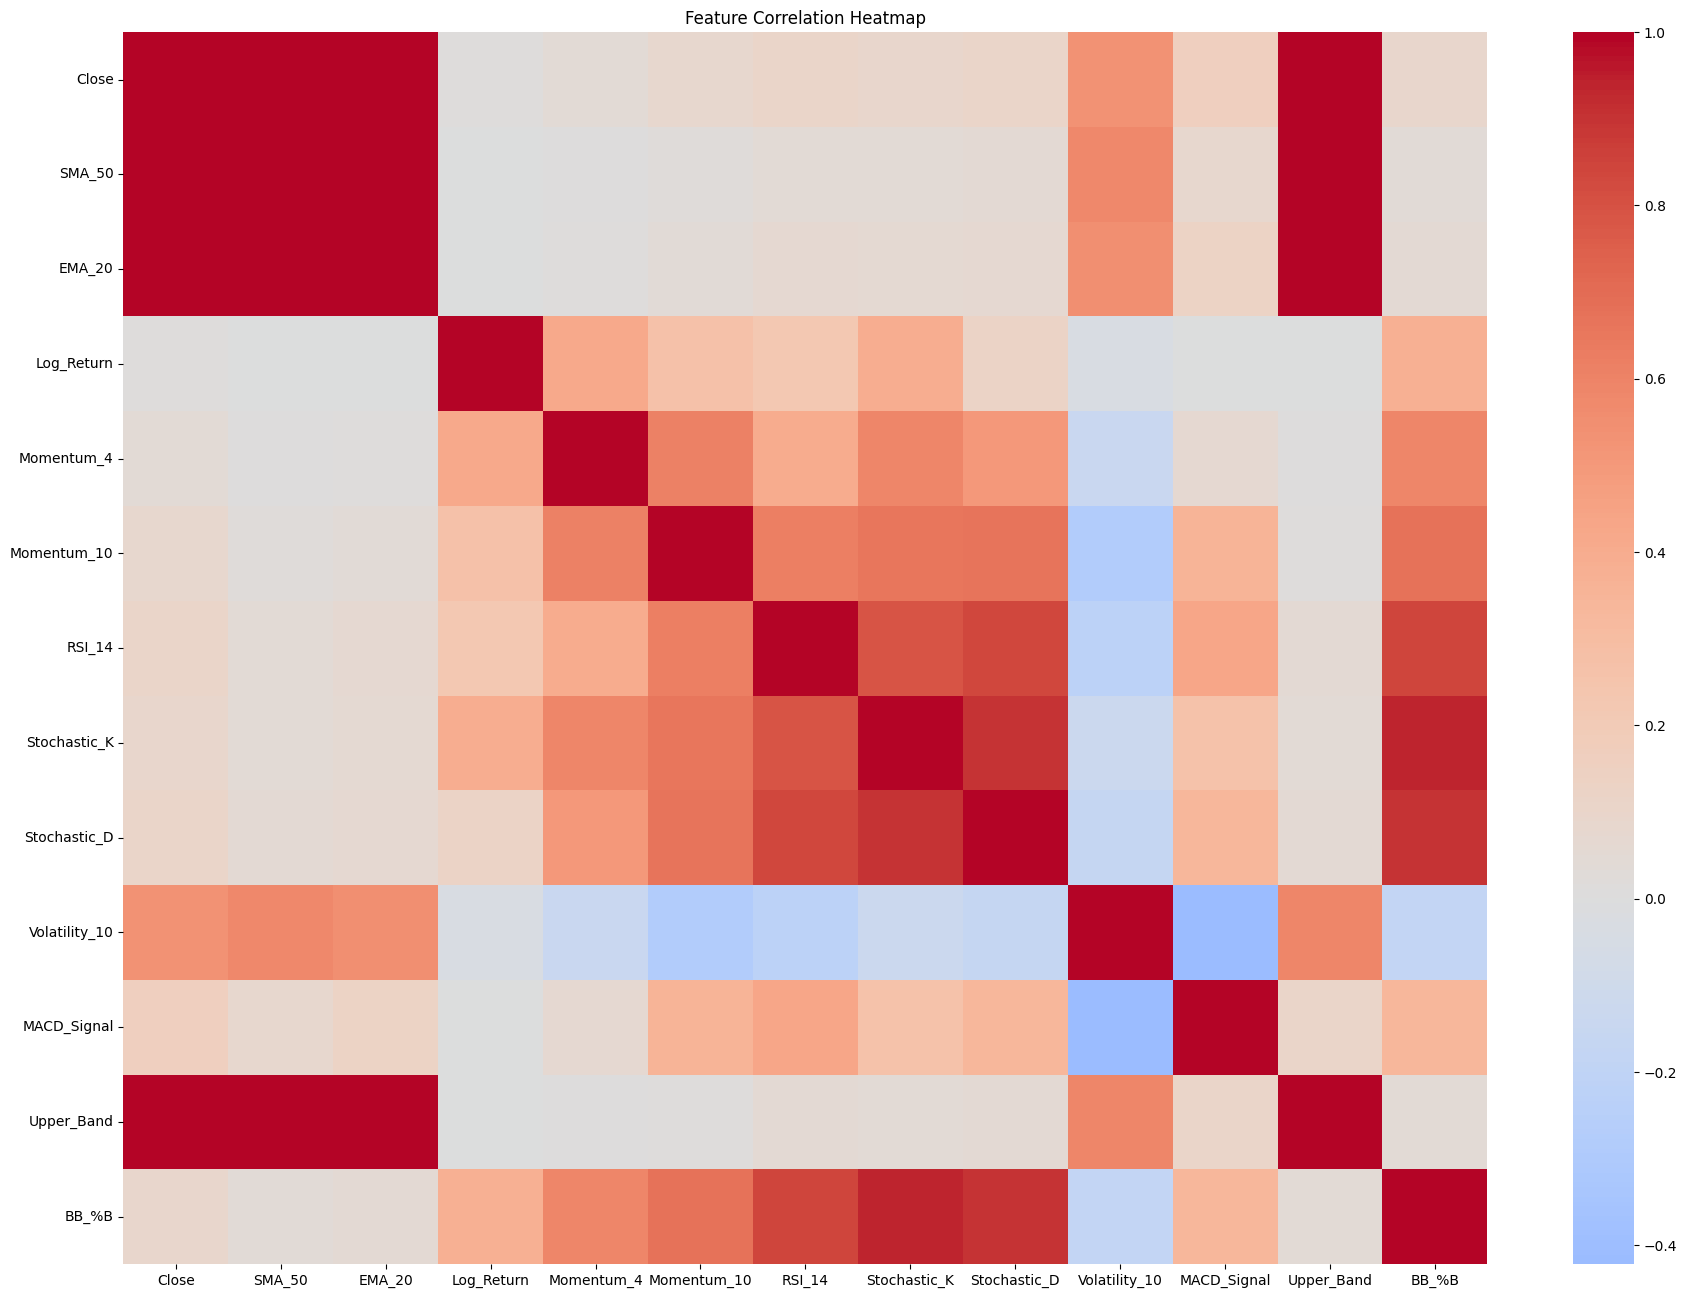

In [28]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(22, 16))
sns.heatmap(df_ml.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [29]:
# ===============================
# Prepare features and target variable for correlation heatmap
# ===============================
X = df_ml.drop(columns=["Log_Return"], errors="ignore") # Features
y = df_ml["Log_Return"] 

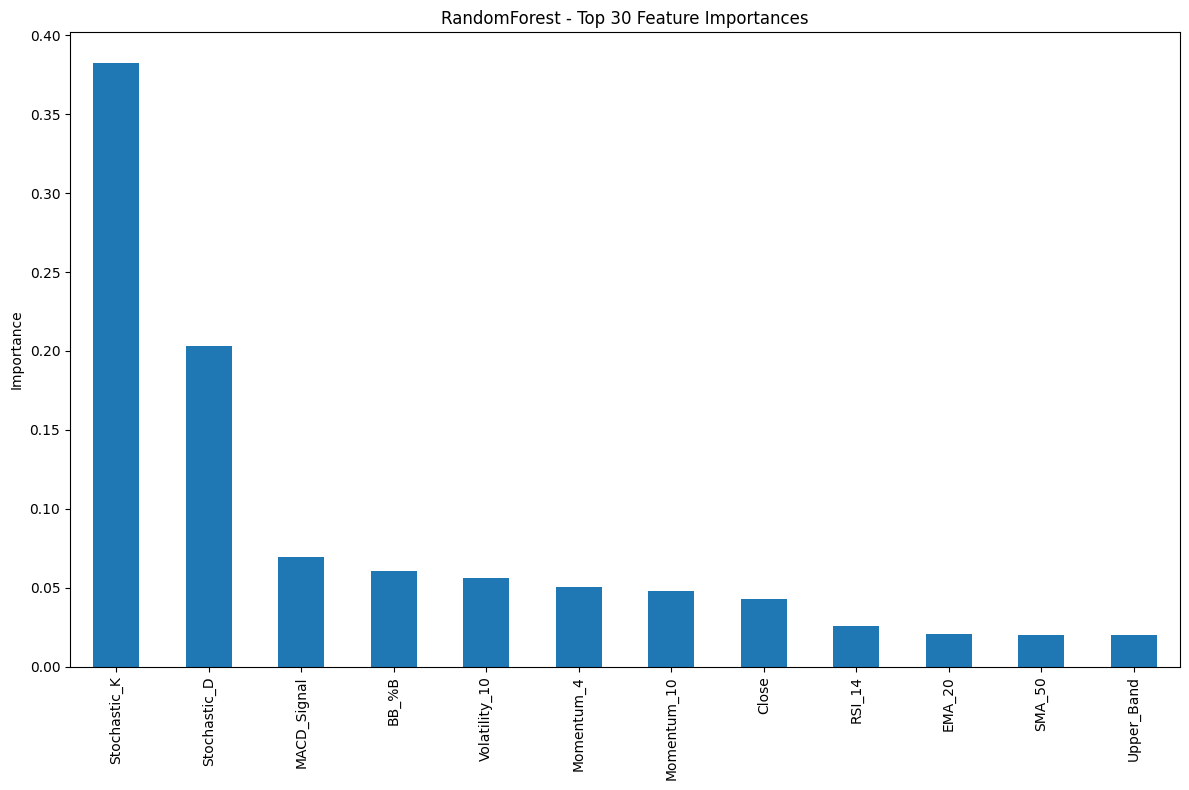

In [30]:
# ===============================
# Random Forest Feature Importances
# ===============================
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importances.head(30).plot(kind="bar")
plt.title("RandomForest - Top 30 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

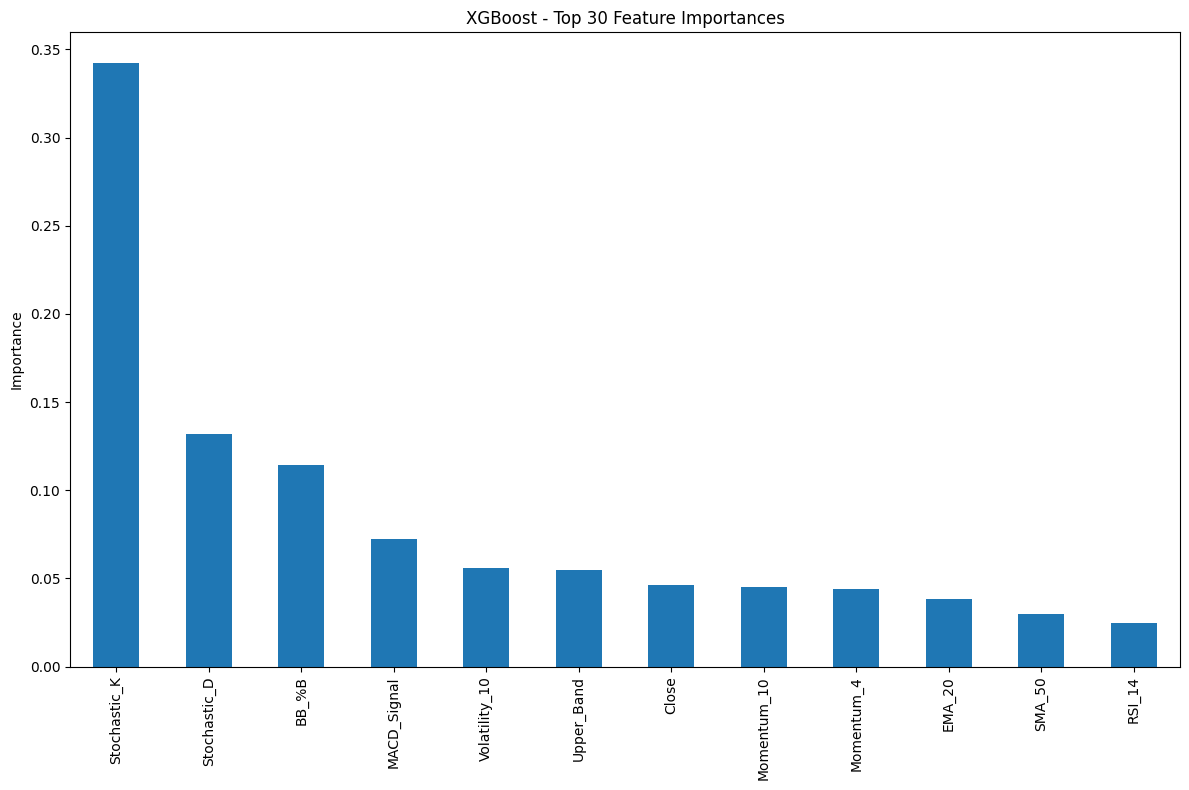

In [31]:
# ===============================
# XGBoost Feature Importances
# ===============================
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)

xgb.fit(X, y)

xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
xgb_importances.head(30).plot(kind="bar")
plt.title("XGBoost - Top 30 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

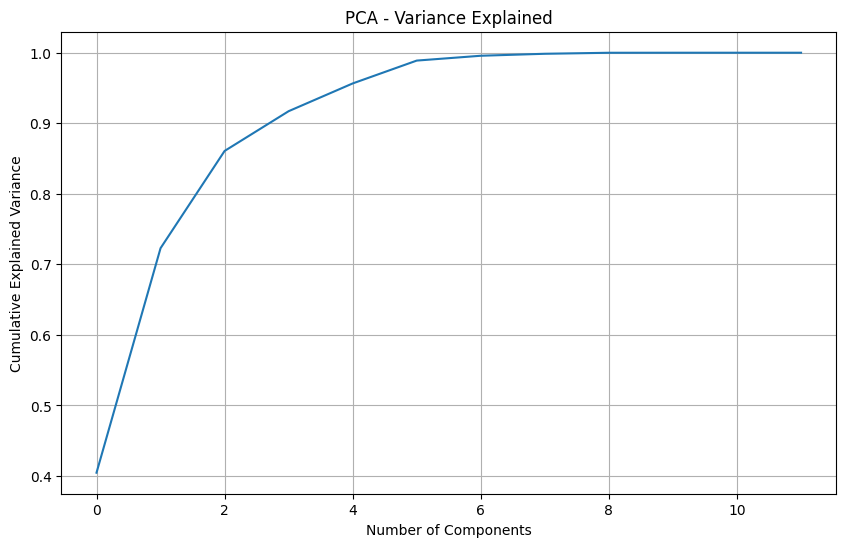

In [32]:
# ===============================
# PCA Variance Explained
# ===============================
pca = PCA()
pca.fit(X)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained')
plt.grid(True)
plt.show()

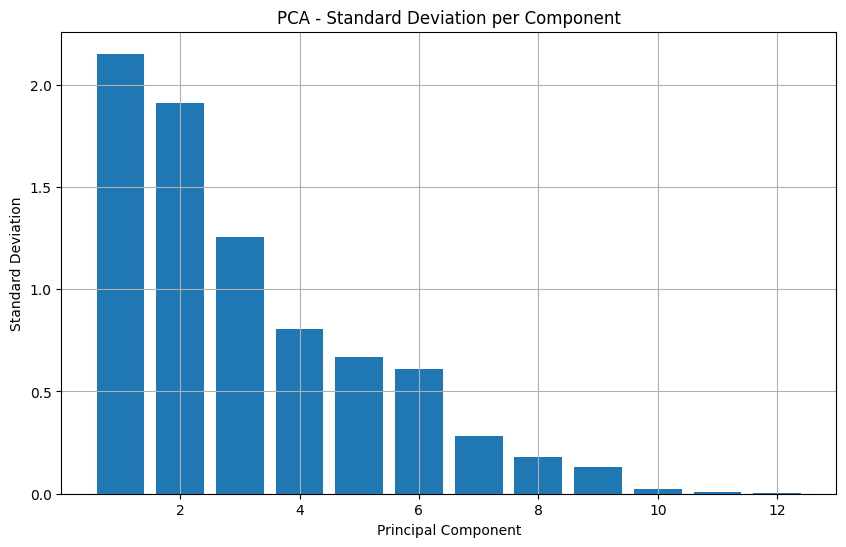

In [33]:
# ===============================
# PCA Variance Explained
# ===============================
explained_variance = pca.explained_variance_
std_dev = np.sqrt(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(std_dev) + 1), std_dev)
plt.xlabel('Principal Component')
plt.ylabel('Standard Deviation')
plt.title('PCA - Standard Deviation per Component')
plt.grid(True)
plt.show()

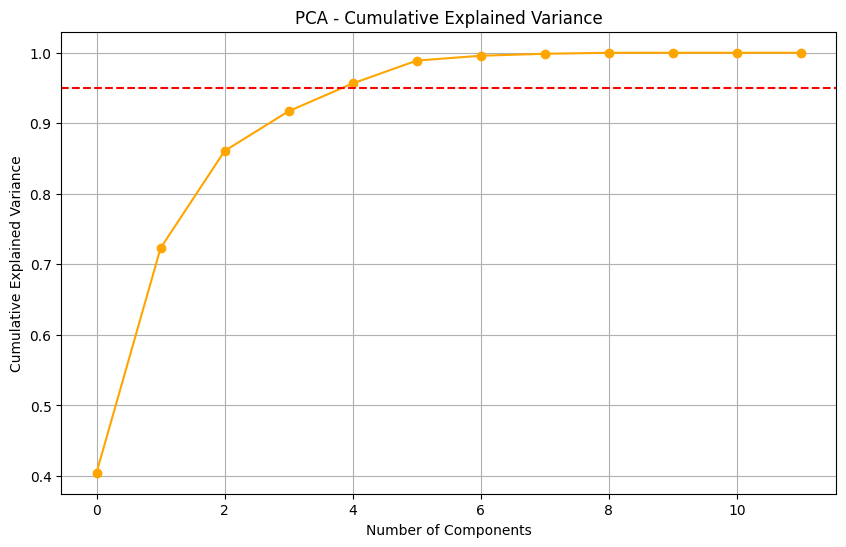

In [34]:
# ===============================
# PCA Variance Explained
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange')
plt.axhline(y=0.95, color='r', linestyle='--')  # Draw a line at 95% variance
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

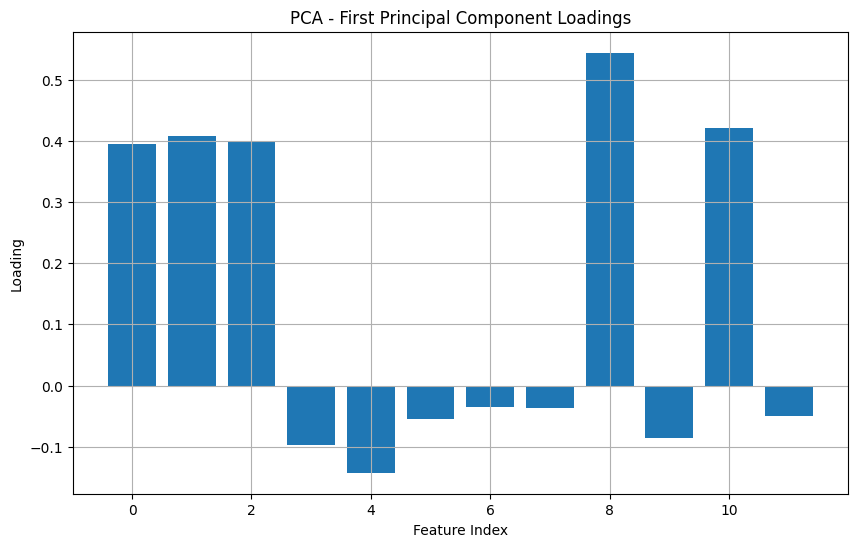

In [35]:
# ===============================
# PCA Principal components
# ===============================
components = pca.components_
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), components[0])
plt.xlabel('Feature Index')
plt.ylabel('Loading')
plt.title('PCA - First Principal Component Loadings')
plt.grid(True)
plt.show()

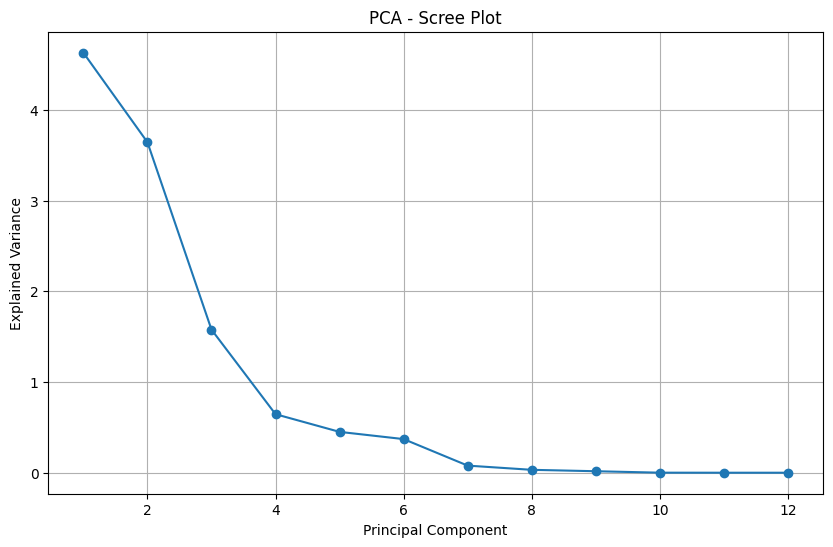

In [36]:
# ===============================
# Scree plot
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA - Scree Plot')
plt.grid(True)
plt.show()

In [37]:
# ===============================
# Some hyperparameters for model training 
# ===============================
SEQ_LEN = 60           # input window (days)
PRED_HORIZON = 1       # predict 1 step ahead (next day), for multi-step, see recursive forecast
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 0.1         # fraction for validation (time split used below)
TEST_SIZE = 0.1        # fraction for test (time split used below)

In [38]:
# ===============================
# Define features and targets
# ===============================
# Required inputs (assumptions)
FEATURE_COLS = ['Close', 
                'SMA_50', 'EMA_20', 
                'Momentum_4', 'Momentum_10',
                'RSI_14', 'Stochastic_K', 'Stochastic_D', 
                'Volatility_10', 
                'MACD_Signal',
                'Upper_Band', 'BB_%B'
              ]
TARGET_COL = "Log_Return"  # the model will predict this (1-step ahead)

In [39]:
# ===============================
# Build sequences
# ===============================
def build_sequences(df, feature_cols, target_col, seq_len=SEQ_LEN, pred_horizon=1):
    """
    Build X, y arrays for supervised learning.
    X shape: (N_samples, seq_len, n_features)
    y shape: (N_samples, pred_horizon)  # pred_horizon=1 gives (N,1)
    """
    data = df[feature_cols].to_numpy()
    target = df[target_col].to_numpy()

    N = len(df)
    X, y = [], []
    last_start = N - seq_len - pred_horizon + 1
    if last_start <= 0:
        raise ValueError("Not enough rows to build sequences. Reduce seq_len or pred_horizo")
    for i in range(last_start):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len : i+seq_len+pred_horizon])
    X = np.array(X)
    y = np.array(y)
    # If pred_horizon==1, allow shape (N,) or (N,1) depending on downstream code. We'll keep (N, pred_horizon)
    return X, y

# Build sequences
X, y = build_sequences(df_ml, FEATURE_COLS, TARGET_COL, seq_len=SEQ_LEN, pred_horizon=PRED_HORIZON)
print("X.shape, y.shape =", X.shape, y.shape)

X.shape, y.shape = (6250, 60, 12) (6250, 1)


In [40]:
# ===============================
# Train/validation (time-ordered)
# ===============================
# Keep time ordering: first 80% train, 10% validation, last 10% test
n_samples = X.shape[0]
train_end = int((1 - VAL_SIZE - TEST_SIZE) * n_samples)
val_end = int((1 - TEST_SIZE) * n_samples)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print("Train samples:", X_train.shape, "Val samples:", X_val.shape[0], "Test samples:", X_test.shape[0])

Train samples: (5000, 60, 12) Val samples: 625 Test samples: 625


In [41]:
# ===============================
# Model definition (stacked LSTM)
# ===============================
def build_lstm_model(seq_len, n_features, d_model=64, dropout=0.1):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.LSTM(d_model, return_sequences=True, recurrent_dropout=dropout)(inp)
    x = layers.LSTM(d_model//2, return_sequences=False,  recurrent_dropout=dropout)(x)
    x = layers.Dense(d_model//2, activation="relu")(x)
    out = layers.Dense(PRED_HORIZON, activation="linear")(x)  # predict scaled Close
    model = models.Model(inp, out)
    return model

n_features = X.shape[2]
model1 = build_lstm_model(SEQ_LEN, n_features, d_model=64, dropout=0.1)
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,217 (129.75 KB)

 Trainable params: 33,217 (129.75 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# ===============================
# Model definition (stacked LSTM)
# ===============================
def build_stack_lstm_model(seq_len, n_features, d_model=64, dropout=0.1):
    inp = layers.Input(shape=(seq_len, n_features))

    # First block
    x = layers.LSTM(d_model, return_sequences=True)(inp)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Second block
    x = layers.LSTM(d_model, return_sequences=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Temporal Attention
    attn = layers.Attention()([x, x])
    x = layers.GlobalAveragePooling1D()(attn)

    # Dense head
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(PRED_HORIZON, activation="linear")(x)

    model = models.Model(inp, out)
    return model

n_features = X.shape[2]
model2 = build_stack_lstm_model(SEQ_LEN, n_features, d_model=64, dropout=0.1)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60, 64)    │     19,712 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ lstm_2[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 64)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60, 64)    │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ lstm_3[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 64)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 64)    │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,633 (272.00 KB)

 Trainable params: 69,633 (272.00 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# ===============================
# Model definition (Residual BiLSTM + Attention)
# ===============================
def build_residual_bilstm(seq_len, n_features, d_model=128, dropout=0.25):
    inp = layers.Input(shape=(seq_len, n_features))

    x1 = layers.Bidirectional(layers.LSTM(d_model, return_sequences=True))(inp)
    x1 = layers.LayerNormalization()(x1)

    x2 = layers.Bidirectional(layers.LSTM(d_model, return_sequences=True))(x1)
    x2 = layers.LayerNormalization()(x2)

    # Residual
    x = layers.Add()([x1, x2])
    x = layers.Dropout(dropout)(x)

    # Attention
    attn = layers.Attention()([x, x])
    x = layers.GlobalMaxPooling1D()(attn)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(PRED_HORIZON)(x)
    return models.Model(inp, out)

n_features = X.shape[2]
model3 = build_residual_bilstm(SEQ_LEN, n_features, d_model=128, dropout=0.25)
model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    144,384 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 256)   │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 256)   │    394,240 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 256)   │        512 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 256)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 60, 256)   │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_1[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 580,865 (2.22 MB)

 Trainable params: 580,865 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# ===============================
# Define the chosen model
# ===============================
model = model2

In [45]:
# ===============================
# Loss, optimizer, metrics and callbacks
# ===============================
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=opt, loss="mse", metrics=["mae", rmse])
earlystop_cb = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_cb = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

In [46]:
# ===============================
# Training
# ===============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=[earlystop_cb, reduce_cb]
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 1.6459 - mae: 0.9313 - rmse: 1.1695 - val_loss: 2.0343 - val_mae: 0.8569 - val_rmse: 1.2609 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.5590 - mae: 0.8915 - rmse: 1.1182 - val_loss: 1.9441 - val_mae: 0.8133 - val_rmse: 1.2150 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.3270 - mae: 0.8044 - rmse: 1.0263 - val_loss: 2.0313 - val_mae: 0.8599 - val_rmse: 1.2612 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.2933 - mae: 0.7891 - rmse: 1.0100 - val_loss: 1.9577 - val_mae: 0.8229 - val_rmse: 1.2238 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.2977 - mae: 0.7895 - rmse: 1.0103 - val_loss: 1.8940 - val_mae: 0.7900 - val_rmse: 1.1891 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.3033 - mae: 0.7968 - rmse: 1.0148 - val_loss: 2.1115 - val_mae:

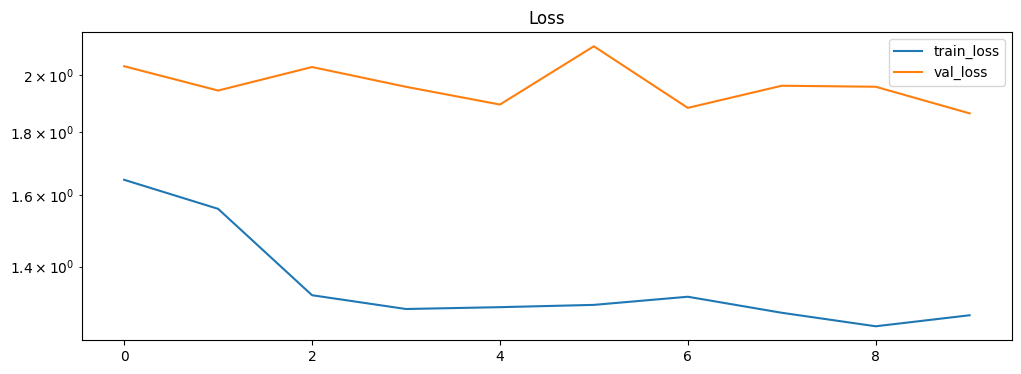

In [47]:
# ===============================
# Plot training loss & metrics
# ===============================
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.yscale("log")
plt.legend(); plt.title("Loss"); plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


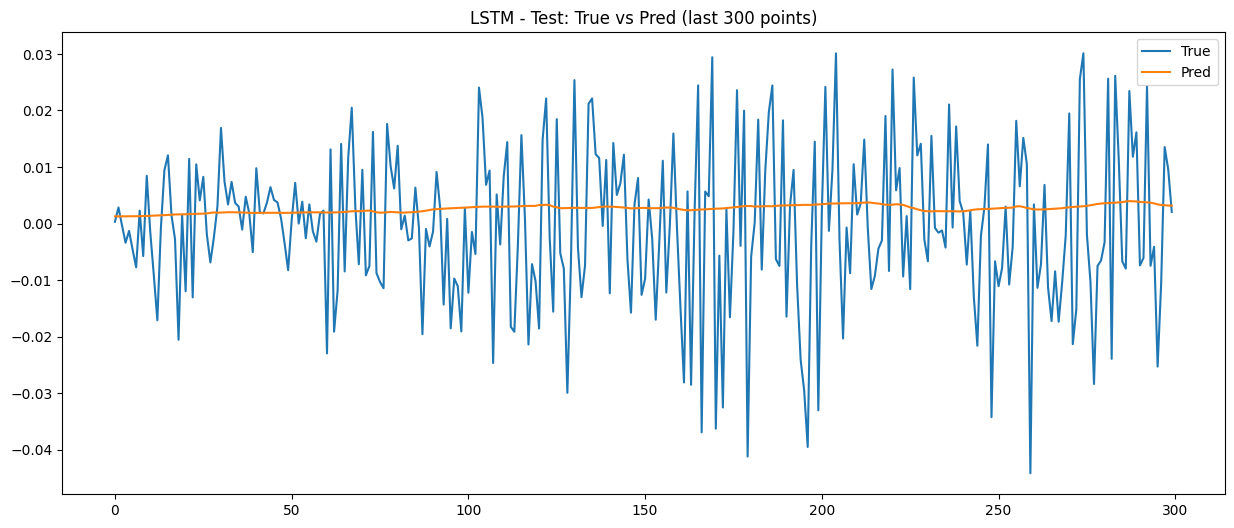

Test metrics (original units): {'MAE': 0.009023669080152834, 'MSE': 0.00014855960205370568, 'RMSE': 0.01218850286350648}


In [109]:
# ===============================
# Evaluate / Predictions (test)
# ===============================
# Predict (scaled)
y_test_pred_scaled = model.predict(X_test)  # shape (N_test, PRED_HORIZON)

# If you scaled the target 'Close' separately
try:
    y_test_pred = log_return_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_test_true = log_return_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
except NameError:
    print("No target scaler found, keeping scaled values")
    y_test_pred = y_test_pred_scaled.flatten()
    y_test_true = y_test.flatten()

# Plot last N points
Nplot = min(300, len(y_test_true))
plt.figure(figsize=(15,6))
plt.plot(y_test_true[-Nplot:], label="True")
plt.plot(y_test_pred[-Nplot:], label="Pred")
plt.legend()
plt.title(f"LSTM - Test: True vs Pred (last {Nplot} points)")
plt.show()

# Compute metrics
def compute_metrics(true, pred):
    true = np.array(true).reshape(-1)
    pred = np.array(pred).reshape(-1)
    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred)**2)
    rmse_v = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse_v}

metrics_test = compute_metrics(y_test_true, y_test_pred)
print("Test metrics (original units):", metrics_test)

In [103]:
# ===============================
# Full series plot - Train + Validation + Test
# ===============================

# Predict scaled values for train, validation, test
y_train_pred_scaled = model.predict(X_train)
y_val_pred_scaled = model.predict(X_val)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform using the target scaler
try:
    y_train_pred = log_return_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_val_pred = log_return_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = log_return_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
except NameError:
    print("No target scaler found, keeping scaled values")
    y_train_pred = y_train_pred_scaled.flatten()
    y_val_pred = y_val_pred_scaled.flatten()
    y_test_pred = y_test_pred_scaled.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [104]:
# ===============================
# Now we unscale the close prices from X, we need to get the last one each time 
# ===============================
close_train_true = [[X_train[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_train))]
unscale = prices_scaler.inverse_transform(np.array(close_train_true))
close_train_true = [u[0] for u in unscale]

close_val_true = [[X_val[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_val))]
unscale = prices_scaler.inverse_transform(np.array(close_val_true))
close_val_true = [u[0] for u in unscale]

close_test_true = [[X_test[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_test))]
unscale = prices_scaler.inverse_transform(np.array(close_test_true))
close_test_true = [u[0] for u in unscale]

print(close_train_true)
print(close_val_true)
print(close_test_true)

[956.0499878, 927.6900024, 939.210022, 952.1199951, 957.9400024, 950.7299805, 961.5100098, 978.5999756, 970.8099976, 963.039978, 957.5900269, 956.9500122, 969.0200195, 977.460022, 985.4899902, 980.2800293, 1001.27002, 1006.0, 1006.900024, 1003.539978, 1012.460022, 1010.73999, 1019.01001, 1020.01001, 1024.140015, 1020.090027, 1022.76001, 1032.079956, 1028.280029, 1034.209961, 1038.140015, 1030.560059, 1042.900024, 1048.670044, 1049.339966, 1047.699951, 1052.02002, 1047.329956, 1035.050049, 1055.689941, 1052.310059, 1064.25, 1068.469971, 1069.920044, 1068.609985, 1079.27002, 1080.449951, 1085.52002, 1089.73999, 1099.160034, 1095.550049, 1105.650024, 1101.930054, 1100.800049, 1095.439941, 1093.599976, 1101.75, 1108.150024, 1120.01001, 1122.699951, 1121.380005, 1109.550049, 1101.650024, 1110.670044, 1109.689941, 1115.75, 1119.319946, 1108.170044, 1122.719971, 1123.650024, 1126.670044, 1130.540039, 1119.579956, 1107.900024, 1086.540039, 1085.109985, 1094.619995, 1111.75, 1121.0, 1122.069946

In [105]:
# ===============================
# Now we compute the predicted close given the old ones and the log return 
# ===============================
close_train_pred = [close_train_true[i] + np.exp(y_train_pred[i]) for i in range(len(X_train))]
close_val_pred = [close_val_true[i] + np.exp(y_val_pred[i]) for i in range(len(X_val))]
close_test_pred = [close_test_true[i] + np.exp(y_test_pred[i]) for i in range(len(X_test))]

print(close_train_pred)
print(close_val_pred)
print(close_test_pred)

[957.0481325458268, 928.6881728354286, 940.2083303605766, 953.1184128350998, 958.9384151879143, 951.7283385708504, 962.5084371314476, 979.5985425851303, 971.8086227592636, 964.0386754596977, 958.5884734837479, 957.9481881786605, 970.0178998992271, 978.4574482714386, 986.4872139944603, 981.2770245106476, 1002.2667254724694, 1006.996702671051, 1007.8968257935753, 1004.536655339077, 1013.4565924083442, 1011.7364115159417, 1020.0061483938789, 1021.0058731396293, 1025.1357164918327, 1021.0857933416862, 1023.755846019516, 1033.0759130765496, 1029.276118398861, 1035.2061792044983, 1039.1362717090988, 1031.5563507566299, 1043.896266582798, 1049.6662381242218, 1050.3361854561958, 1048.6962196896325, 1053.016336552162, 1048.3263345409928, 1036.0465234448661, 1056.6865285148774, 1053.3066627869453, 1065.2466442584991, 1069.4665893900833, 1070.9165681551399, 1069.6064339340783, 1080.2664732256126, 1081.4464559028397, 1086.5164887824249, 1090.7363283078575, 1100.1562666288223, 1096.5461342265357, 1

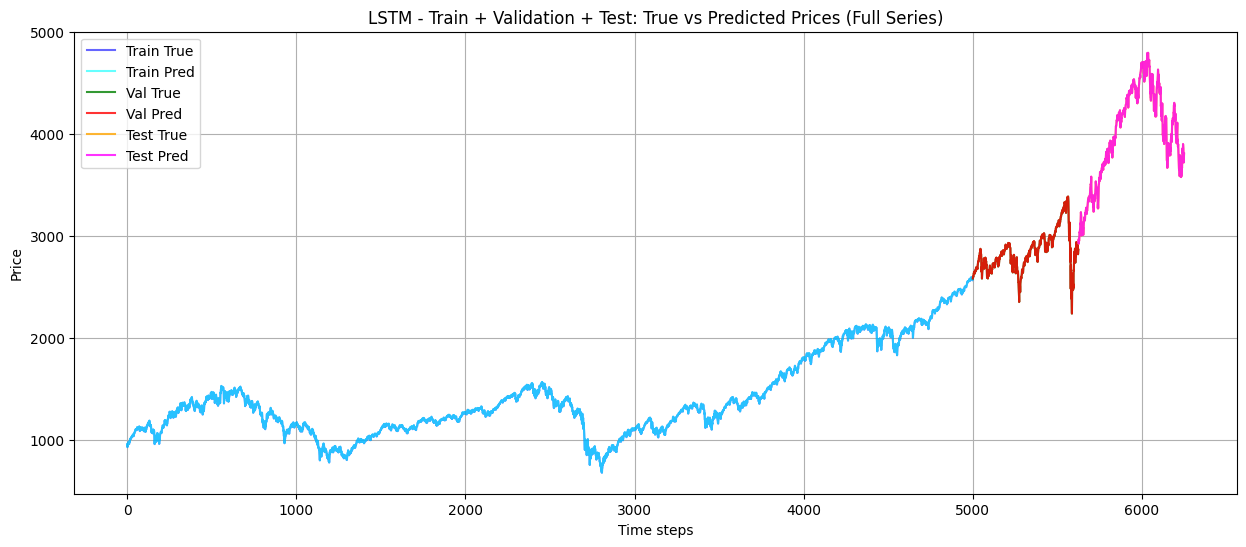

Training metrics (original units): {'MAE': 0.9997818028211594, 'MSE': 0.9995717086120102, 'RMSE': 0.9997858313719045}
Validation metrics (original units): {'MAE': 1.0017541477203369, 'MSE': 1.0035117826166953, 'RMSE': 1.0017543524321195}
Test metrics (original units): {'MAE': 1.002475121307373, 'MSE': 1.004956771273634, 'RMSE': 1.0024753220272478}


In [110]:
# ===============================
# Plot the full series
# ===============================
plt.figure(figsize=(15,6))
plt.plot(close_train_true, label="Train True", color='blue', alpha=0.6)
plt.plot(close_train_pred, label="Train Pred", color='cyan', alpha=0.6)
plt.plot(range(len(close_train_true), len(close_train_true)+len(close_val_true)), close_val_true, label="Val True", color='green', alpha=0.8)
plt.plot(range(len(close_train_true), len(close_train_true)+len(close_val_true)), close_val_pred, label="Val Pred", color='red', alpha=0.8)
plt.plot(range(len(close_train_true)+len(close_val_true), len(close_train_true)+len(close_val_true)+len(close_test_true)), close_test_true, label="Test True", color='orange', alpha=0.8)
plt.plot(range(len(close_train_true)+len(close_val_true), len(close_train_true)+len(close_val_true)+len(close_test_true)), close_test_pred, label="Test Pred", color='magenta', alpha=0.8)
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.title("LSTM - Train + Validation + Test: True vs Predicted Prices (Full Series)")
plt.legend()
plt.grid(True)
plt.show()

# Compute metrics
def compute_metrics(true, pred):
    true = np.array(true).reshape(-1)
    pred = np.array(pred).reshape(-1)
    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred)**2)
    rmse_v = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse_v}

metrics_train = compute_metrics(close_train_true, close_train_pred)
metrics_val = compute_metrics(close_val_true, close_val_pred)
metrics_test = compute_metrics(close_test_true, close_test_pred)

print("Training metrics (original units):", metrics_train)
print("Validation metrics (original units):", metrics_val)
print("Test metrics (original units):", metrics_test)

seems to copy paste the serie on this visual, maybe not the best one but will allow a better recursive forecast

In [121]:
# ===============================
# Recursive multi-step forecast (future) by re-updating features at each step
# ===============================
def scale_features_row(df_row):
    df_scaled = df_row.copy()
    # Price features
    df_scaled[price_cols] = prices_scaler.transform(df_row[price_cols])
    # Indicators
    for col, scaler in indicators_scalers.items():
        df_scaled[col] = scaler.transform(df_row[[col]])
    return df_scaled

def recursive_forecast_updated(model, df_history, last_sequence, last_close, n_steps=200):
    """
    Fully consistent recursive forecast with:
    inverse-transform --> recompute --> rescale

    last_sequence: (seq_len, n_features) scaled
    feature_cols: list of feature names in the sequence
    target_idx: index of the target column (Close) in feature_cols
    """
    seq = last_sequence.copy()
    preds = []

    close_scaled = [[last_close for _ in range(len(price_cols))]]
    unscale = prices_scaler.inverse_transform(np.array(close_scaled))
    last_close_value = unscale[0][0]

    df_hist = df_history.copy()

    for _ in range(n_steps):
        # 1. Predict next Close (scaled)
        x = seq[np.newaxis, ...]
        pred_logreturn_scaled = model.predict(x)[0, 0]

        # 2. Get the last data available
        last_row = df_hist.iloc[-1].copy()
        new_row = last_row.copy()

        # 2. Inverse scale logreturn to compute the new row close
        logreturn = log_return_scaler.inverse_transform([[pred_logreturn_scaled]])[0, 0]
        pred_close = last_close_value + np.exp(logreturn)
        preds.append(pred_close)
        last_close_value = pred_close
        new_row["Close"] = pred_close

        # 4. Append & recompute ALL features
        df_hist = df_history.copy()
        df_hist = pd.concat([df_hist, new_row.to_frame().T], ignore_index=True)
        df_hist = preprocess_data(df_hist)
        df_hist = df_hist.select_dtypes(include=[np.number]).dropna()
        df_hist = df_hist.replace([np.inf, -np.inf], np.nan)
        df_hist = df_hist.dropna()

        # 5. Take last row & scale it correctly
        df_scaled = scale_features_row(df_hist)
        last_features_scaled = df_scaled.iloc[-1:][FEATURE_COLS]

        # 6. Slide window
        seq = np.vstack([seq[1:], last_features_scaled.values])

    return np.array(preds)

In [125]:
# ===============================
# Recursive multi-step forecast (future) by re-updating features at each step (computation)
# ===============================
# future forecast
N_FUTURE = 1000
future_preds = recursive_forecast_updated(
    model,
    df_history=df_raw_hist,    # UNSCALED dataframe
    last_sequence=X_test[-1],
    last_close=X_test[-1][-1][0],
    n_steps=N_FUTURE
)

# Predict scaled values
y_train_pred_scaled = model.predict(X_train)
y_val_pred_scaled   = model.predict(X_val)
y_test_pred_scaled  = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [126]:
# ===============================
# Recursive multi-step forecast (future) by re-updating features at each step (finding back close prices)
# ===============================
# Inverse transform
y_train_pred = log_return_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_val_pred = log_return_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = log_return_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Now we unscale the close prices from X, we need to get the last one each time 
close_train_true = [[X_train[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_train))]
unscale = prices_scaler.inverse_transform(np.array(close_train_true))
close_train_true = [u[0] for u in unscale]

close_val_true = [[X_val[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_val))]
unscale = prices_scaler.inverse_transform(np.array(close_val_true))
close_val_true = [u[0] for u in unscale]

close_test_true = [[X_test[i][-1][0] for _ in range(len(price_cols))] for i in range(len(X_test))]
unscale = prices_scaler.inverse_transform(np.array(close_test_true))
close_test_true = [u[0] for u in unscale]

# Now we compute the predicted close given the old ones and the log return 
close_train_pred = [close_train_true[i] + np.exp(y_train_pred[i]) for i in range(len(X_train))]
close_val_pred = [close_val_true[i] + np.exp(y_val_pred[i]) for i in range(len(X_val))]
close_test_pred = [close_test_true[i] + np.exp(y_test_pred[i]) for i in range(len(X_test))]

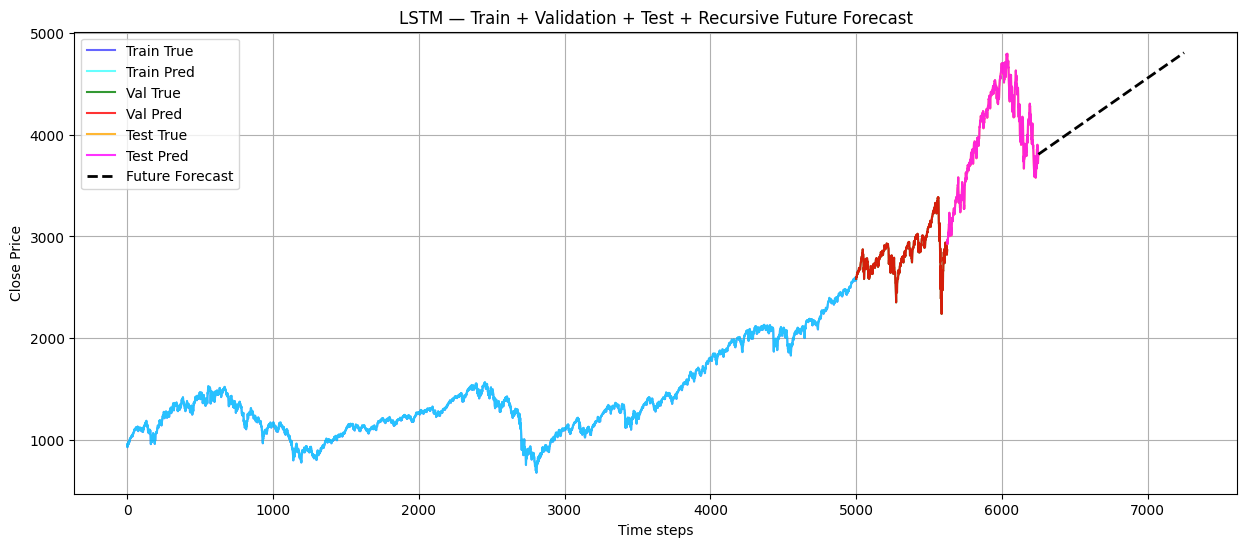

In [127]:
# ===============================
# Plot the full series
# ===============================
plt.figure(figsize=(15,6))

# Train
plt.plot(close_train_true, label="Train True", color='blue', alpha=0.6)
plt.plot(close_train_pred, label="Train Pred", color='cyan', alpha=0.6)

# Validation
val_x = range(len(close_train_true), len(close_train_true)+len(close_val_true))
plt.plot(val_x, close_val_true, label="Val True", color='green', alpha=0.8)
plt.plot(val_x, close_val_pred, label="Val Pred", color='red', alpha=0.8)

# Test
test_x = range(len(close_train_true)+len(close_val_true), len(close_train_true)+len(close_val_true)+len(close_test_true))
plt.plot(test_x, close_test_true, label="Test True", color="orange", alpha=0.8)
plt.plot(test_x, close_test_pred, label="Test Pred", color="magenta", alpha=0.8)

# Future
future_x = range(len(close_train_true)+len(close_val_true)+len(close_test_true), len(close_train_true)+len(close_val_true)+len(close_test_true)+ N_FUTURE)
plt.plot(future_x, future_preds, label="Future Forecast", color="black", linestyle="--", linewidth=2)

plt.xlabel("Time steps")
plt.ylabel("Close Price")
plt.title("LSTM — Train + Validation + Test + Recursive Future Forecast")
plt.legend()
plt.grid(True)
plt.show()